<a href="https://colab.research.google.com/github/lovgon/stepik-fast-start_to_AI/blob/main/3_5_requrent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекуррентные нейронные сети на практике. Шифр Цезаря.

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

Параметр шифрования ключ K и наш алфавит:

In [2]:
key = 2
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ']

Функция кодирования:


In [3]:
def encrypt(text, key):
    """Returns the encrypted form of 'text'."""

    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(key + idx) % len(vocab) for idx in indexes]   
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)

    return encrypted

print(encrypt('RNN IS NOT AI', key))

TPPAKUAPQVACK


Зависимость индексов исходных букв от индексов зашифрованных букв при k=10:

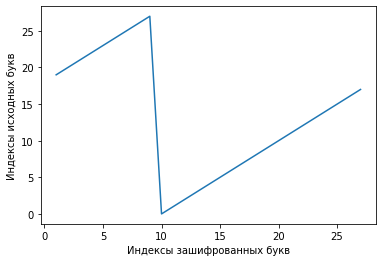

In [4]:
import matplotlib.pyplot as plt
import numpy as np

key = 10
plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - key) %  len(vocab))
plt.ylabel('Индексы исходных букв')
plt.xlabel('Индексы зашифрованных букв')
plt.show()

Собираем датасет:

In [5]:
num_examples = 256 # размер датасета
seq_len = 18 # максимальная длина строки


def encrypted_dataset(dataset_len, k):
    """
    Return: List(Tuple(Tensor encrypted, Tensor source))
    """
    dataset = []
    for x in range(dataset_len):
        random_message  = ''.join([random.choice(vocab) for _ in range(seq_len)])
        encrypt_random_message = encrypt(''.join(random_message), k)
        src = [vocab.index(char) for char in random_message]
        tgt = [vocab.index(char) for char in encrypt_random_message]
        dataset.append([torch.tensor(tgt), torch.tensor(src)])
    return dataset

Пример объекта:

In [6]:
df = encrypted_dataset(num_examples, k=2)
example = df[0]
example

[tensor([ 8, 16, 26, 22,  7, 25,  0, 18, 20, 27,  4, 25, 12, 11, 22, 16, 16, 27]),
 tensor([ 6, 14, 24, 20,  5, 23, 26, 16, 18, 25,  2, 23, 10,  9, 20, 14, 14, 25])]

**Pytorch RNN:**
$$h_t = \text{tanh}(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})$$

**$h_t$ - скрытое состояние на момент $t$<br> $x_t$ - эмбеддинг символа момента времени $t$ <br> $h_{t-1}$ - скрытое состояние на момент $t-1$**


Аргументы RNN:

$input\_size$: размер эмбеддингов символов $x$ <br>
$hidden\_size$: размер скрытого состояния $h$ <br>
$num\_layers$: количество слоев <br>

Модель:

In [7]:
class Decipher(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 rnn_type='simple'):
        """
        :params: int vocab_size 
        :params: int embedding_dim
        :params
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        if rnn_type == 'simple':
            self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)
         
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(num_layers, 1, hidden_dim)

        
    def forward(self, cipher):
        # CHECK INPUT SIZE
        # Unsqueeze 1 dimension for batches
        embd_x = self.embed(cipher).unsqueeze(1)
        
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
        
        return self.fc(out_rnn).transpose(1, 2)    

Параметры нашей модели:

In [8]:
embedding_dim = 5
hidden_dim = 10
num_layers=2
vocab_size = len(vocab) 
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()

# Инициализируйте модель
model = Decipher(vocab_size, embedding_dim, hidden_dim, num_layers)

# Инициализируйте оптимизатор: рекомендуется Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

num_epochs = 7

Количество обучаемых параметров в сети:

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 838 trainable parameters


Обучение модели:

Epoch: 0
Loss: 2.7026


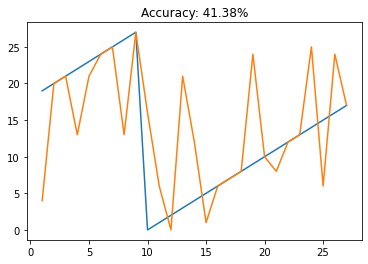

Epoch: 1
Loss: 1.8049


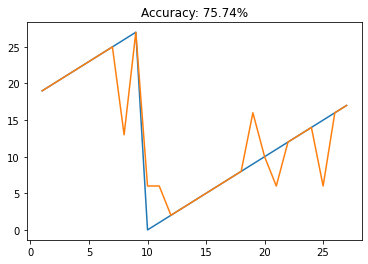

Epoch: 2
Loss: 1.1958


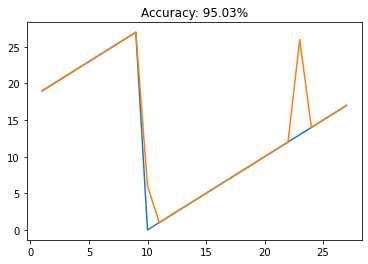

Epoch: 3
Loss: 0.8440


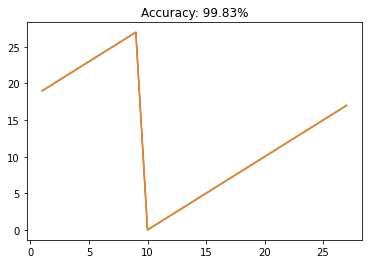

Epoch: 4
Loss: 0.6454


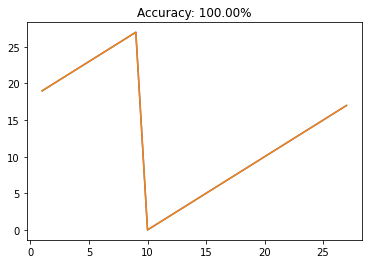

Epoch: 5
Loss: 0.3630


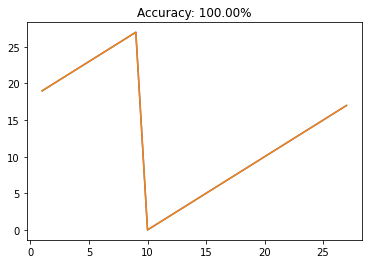

Epoch: 6
Loss: 0.2893


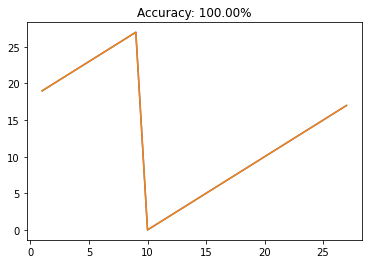

In [10]:
k = 10
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in encrypted_dataset(num_examples, k):

        scores = model(encrypted)
        original = original.unsqueeze(1)
        # Calculate loss
        loss = criterion(scores, original)
        # Zero grads
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))

    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in encrypted_dataset(num_examples, k):
            # Compute a softmax over the outputs
            predictions = F.softmax(model(encrypted), dim=1)
            # Choose the character with the maximum probability (greedy decoding)
            _, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total

        plt.title('Accuracy: {:4.2f}%'.format(accuracy * 100))
        plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - 10) %  len(vocab))
        with torch.no_grad():
            plt.plot(range(1, len(vocab)), F.softmax(model(torch.tensor(range(1, len(vocab)))), 1).max(dim=1)[1])
        plt.show()

Матрицы переходов $W_{ih}, W_{hh}$:

In [11]:
from scipy import linalg
list(map(linalg.norm, [model.rnn.weight_ih_l0.data, model.rnn.weight_hh_l0.data]))

[4.3569794, 0.9039031]

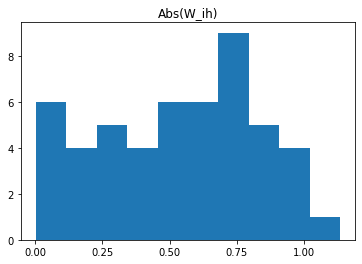

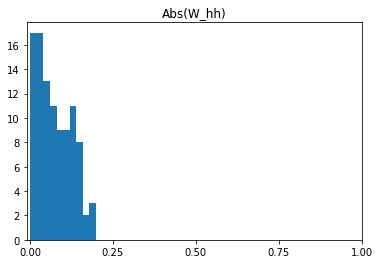

In [12]:
W_ih = model.rnn.weight_ih_l0.data.abs().numpy().ravel()
plt.title('Abs(W_ih)')
plt.hist(W_ih)
plt.xticks(np.linspace(0, 1, 5))
plt.show()

W_hh = model.rnn.weight_hh_l0.data.abs().numpy().ravel()
plt.title('Abs(W_hh)')
plt.hist(W_hh)
plt.xticks(np.linspace(0, 1, 5))
plt.show()

Проверка работы модели:

In [13]:
key = 10
print(encrypt('RNN IS NOT AI', key))

-XXISAIXYBIKS


In [14]:
encrypt_message= '-XXISAIXYBIKS'
encrypt_tensor = torch.tensor([vocab.index(char) for char in encrypt_message])
with torch.no_grad():
    real_tensor = model(encrypt_tensor)
    real_indexes = real_tensor.max(dim=1)[1].numpy().ravel()
    print(''.join([vocab[real_index] for real_index in real_indexes]))

RNN IS NOT AI
